In [1]:
import sys
sys.path.insert(0,'..')
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from relu import ReLUAlpha

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nx36v7lb because the default path (/home/david.bertoin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class Net(nn.Module):

    def __init__(self, nb_neurons=512, nb_hidden_layers=2):
        super(Net, self).__init__()
        mlp = [torch.nn.Linear(28 * 28, nb_neurons)]
        for _ in range(nb_hidden_layers-1):
            mlp.append(torch.nn.Linear(nb_neurons, nb_neurons))
        mlp.append(torch.nn.Linear(nb_neurons, 10))
        self.total_relu = self._get_total_relu(mlp)
        self.mlp = torch.nn.Sequential(*mlp)
        
    def forward(self, x):
        total_relu = self.total_relu * len(x)
        count=0
        for l in self.mlp[:-1]:
            x = l(x)
            count += torch.count_nonzero(x)
            x = torch.relu(x)
        x = self.mlp[-1](x)

        return x, (total_relu - count).item(), total_relu
    
    def _get_total_relu(self, mlp):
        count = 0
        for l in mlp[:-1]:
            count += l.out_features
        return count

In [3]:
batch_size = 256
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
nb_neurons = 256
df = pd.DataFrame(columns=["zeros", "total_relu", "nb_layers", "nb_neurons", "precision", "epoch"])
for precision in tqdm([16,32], desc='precision'):
    for nb_layers in tqdm([1,2,3,5,6], desc='nb_layers', leave=False):
        for nb_neurons in tqdm([16, 64, 256, 512], desc='nb_neurons', leave=False):
            net = Net(nb_neurons, nb_layers).to(device)
            optimizer = optim.SGD(net.parameters(), lr=0.01,
                            momentum=0.9, weight_decay=5e-4)
            if precision == 16:
                net.half()
            if precision == 64:
                net.double()
            for epoch in tqdm(range(100), desc='epoch_loop', leave=False):
                train_loss = 0
                correct = 0
                total = 0
                total_zeros = 0
                total_relu = 0
                bar = tqdm(iter(train_loader), desc='batch_loop', leave=False)
                for x, y in bar:
                    optimizer.zero_grad()
                    x = x.to(device)
                    if precision == 16:
                        x = x.half()
                    if precision == 64:
                        x = x.double()
                    y = y.to(device)
                    y_hat, zeros, relus = net(x.view(-1, 28 * 28))
                    total_zeros += zeros
                    total_relu += relus
                    loss = nn.CrossEntropyLoss()(y_hat, y)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                    _, predicted = y_hat.max(1)
                    total += y.size(0)
                    correct += predicted.eq(y).sum().item()
                    bar.set_description("accuracy %0.2f" % (100*correct/total))

                df = df.append({"zeros": total_zeros,
                                "nb_layers": nb_layers,
                                "nb_neurons": nb_neurons,
                                "precision": precision,
                                "epoch": epoch,
                                "total_relu": total_relu}, ignore_index=True)

precision:   0%|          | 0/2 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/4 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

epoch_loop:   0%|          | 0/100 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

batch_loop:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
df["cum_zeros"] = 0
df["cum_relu"] = 0
dfl = []
for precision in tqdm([16,32], desc='precision'):
    for nb_layers in tqdm([1,2,3,5,6], desc='nb_layers', leave=False):
        for nb_neurons in tqdm([16, 64, 256, 512], desc='nb_neurons', leave=False):
            tmp = df[(df['nb_neurons'] == nb_neurons) & (df['nb_layers'] == nb_layers) & (df['precision'] == precision)]
            tmp["cum_zeros"] = tmp["zeros"].cumsum()
            tmp["cum_relu"] = tmp["total_relu"].cumsum()
            dfl.append(tmp)
df = pd.concat(dfl, ignore_index=True)
df.to_csv("zeros_by_architecture.csv")

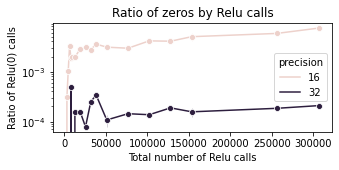

In [2]:
df = pd.read_csv("zeros_by_architecture.csv")
df["zeros"] = pd.to_numeric(df["zeros"])
df["total_relu"] = pd.to_numeric(df["total_relu"])
df["ratio_zeros"] = df["zeros"] / df["total_relu"]
df["total_activations"] = df["nb_layers"] * df["nb_neurons"]

v = df[["nb_layers","nb_neurons","precision"]]
v = np.array(v)
v = [str(i) for i in v]
a = v[1:]  
b = v[:-1]
b.insert(0,v[0])
a.insert(0,v[0])

grouper = np.array([a[i] != b[i] for i in range(len(a))])
grouper = np.cumsum(grouper)

df.cum_zeros = df.groupby(grouper)["zeros"].cumsum()
df.cum_relu = df.groupby(grouper)["total_activations"].cumsum()
df["ratio_zeros"] = df["cum_zeros"] / df["cum_relu"]

plt.figure(figsize=(5,2))

g_results = sns.lineplot(data=df[df["epoch"]==99], x="cum_relu", y="ratio_zeros",  hue="precision", marker='o')#, dashes=False)
g_results.set(yscale='log')
plt.title(f"Ratio of zeros by Relu calls")
plt.xlabel("Total number of Relu calls")
plt.ylabel("Ratio of Relu(0) calls")
plt.savefig('proportionZeroCall.pdf')